<a href="https://colab.research.google.com/github/lasyaEd/computerVision/blob/main/Chapter7_UnderstandingSelectiveSearch_ledunuri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding SelectiveSearch

1. Install the required packages.

In [1]:
!pip install selectivesearch
!pip install torch_snippets
!pip install gdown
from torch_snippets import *
import selectivesearch
from skimage.segmentation import felzenszwalb

2. Fetch and load the required image

In [2]:
# !wget https://www.dropbox.com/s/l98leemr7r5stnm/Hemanvi.jpeg
import gdown
id = "17qLhBl9rA1usrfICMh4PjvV2MZQC0P6k"
gdown.download(id=id, output='Hemanvi.png')
img = read('Hemanvi.png', 1)

Downloading...
From: https://drive.google.com/uc?id=17qLhBl9rA1usrfICMh4PjvV2MZQC0P6k
To: /content/Hemanvi.png
100%|██████████| 646k/646k [00:00<00:00, 134MB/s]


3. Extract the felzenszwalb segments (which are obtained based on the
color, texture, size, and shape compatibility of content within an image)
from the image.

In [8]:
# FILL IN
segments_fz = felzenszwalb(img, scale=200) #the larger the scale number the fewer the clusters.

Starts with each pixel as its own segment, iteratively merges pixels if the merge meets the segmentation criteria (if difference is less than a certain threshold) and continues until no more merges possible


*   large threshold (large scale) means algo is more permissive to merging regions -> fewer, larger segments
*   Small threshold (small scale) means algo will only merge regions that are very similar -> more, finer segments.

4. Plot the original image and the image with segmentation

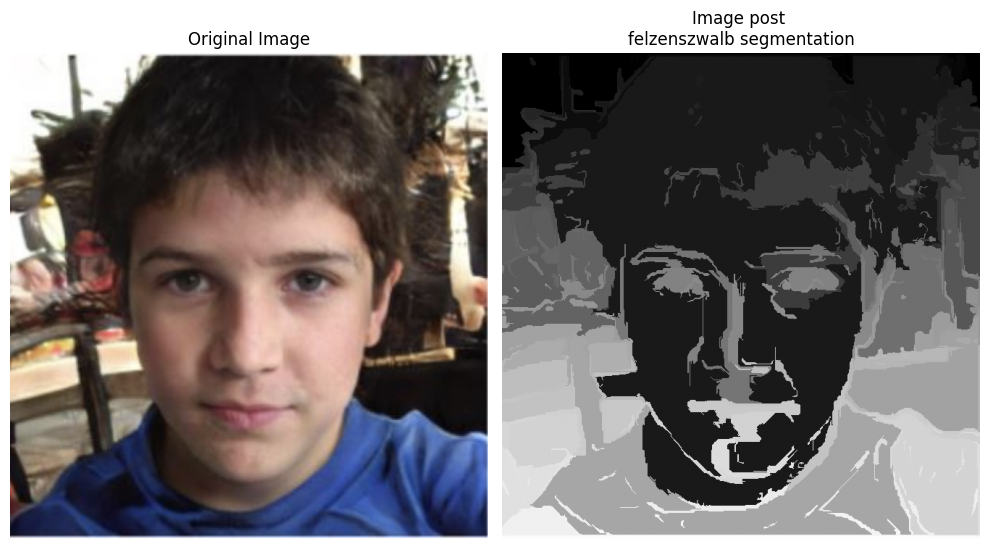

In [9]:
subplots([img, segments_fz],
         titles=['Original Image','Image post \nfelzenszwalb segmentation'],
         figsize=(10,10), nc=2)

* From the preceding output, note that pixels that belong to the same group have
similar pixel values.
* Pixels that have similar values form a region proposal. This now
helps in object detection, as we now pass each region proposal to a
network and ask it to predict whether the region proposal is a
background or an object. If it is an object, it would
help us to identify the offset to fetch the tight bounding box
corresponding to the object and also the class corresponding to the
content within the region proposal.
# Implementing SelectiveSearch to Generate Region Proposals
1. Define the extract_candidates function that fetches the region
proposals from an image.
* Define the function that takes an image as the input parameter.
  * scale: Felzenszwalb Scale (discussed above)
  * sigma: width of gaussian smoothing filter applied to image during preprocessing. Larger sigma = more smoothing. Smaller sigma = less smoothing.
  * min_size = minimum size of the segments. if segment is smaller than this, it will be merged with neighboring segment.
* Fetch the candidate regions within the image using the
selective_search method available in the selectivesearch
package.
* Calculate the image area and initialize a list (candidates) that we will
use to store the candidates that pass a defined threshold.
* Fetch only those candidates (regions) that are over 5% of the total
image area and less than or equal to 100% of the image area and return
them.

In [10]:
# function takes an image as the input parameter
def extract_candidates(img):
    # Fetch the candidate regions
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100) #i only want a cluster of pixel area 100.
    # print(regions[0])
    # Calculate the image area and initialize a candidates list
    img_area = np.prod(img.shape[:2])
    candidates = []
    # Fetch candidates that are over 5% of the total image area and less than or equal to 100% of the image area
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
        # break
    return candidates

2. Import the relevant packages and fetch an image.

In [11]:
!pip install selectivesearch
!pip install torch_snippets
!pip install gdown
from torch_snippets import *
import selectivesearch

import gdown
id = "17qLhBl9rA1usrfICMh4PjvV2MZQC0P6k"
gdown.download(id=id, output='Hemanvi.png')
img = read('Hemanvi.png', 1)

Downloading...
From: https://drive.google.com/uc?id=17qLhBl9rA1usrfICMh4PjvV2MZQC0P6k
To: /content/Hemanvi.png
100%|██████████| 646k/646k [00:00<00:00, 93.6MB/s]


3. Extract candidates and plot them on top of an image.

55


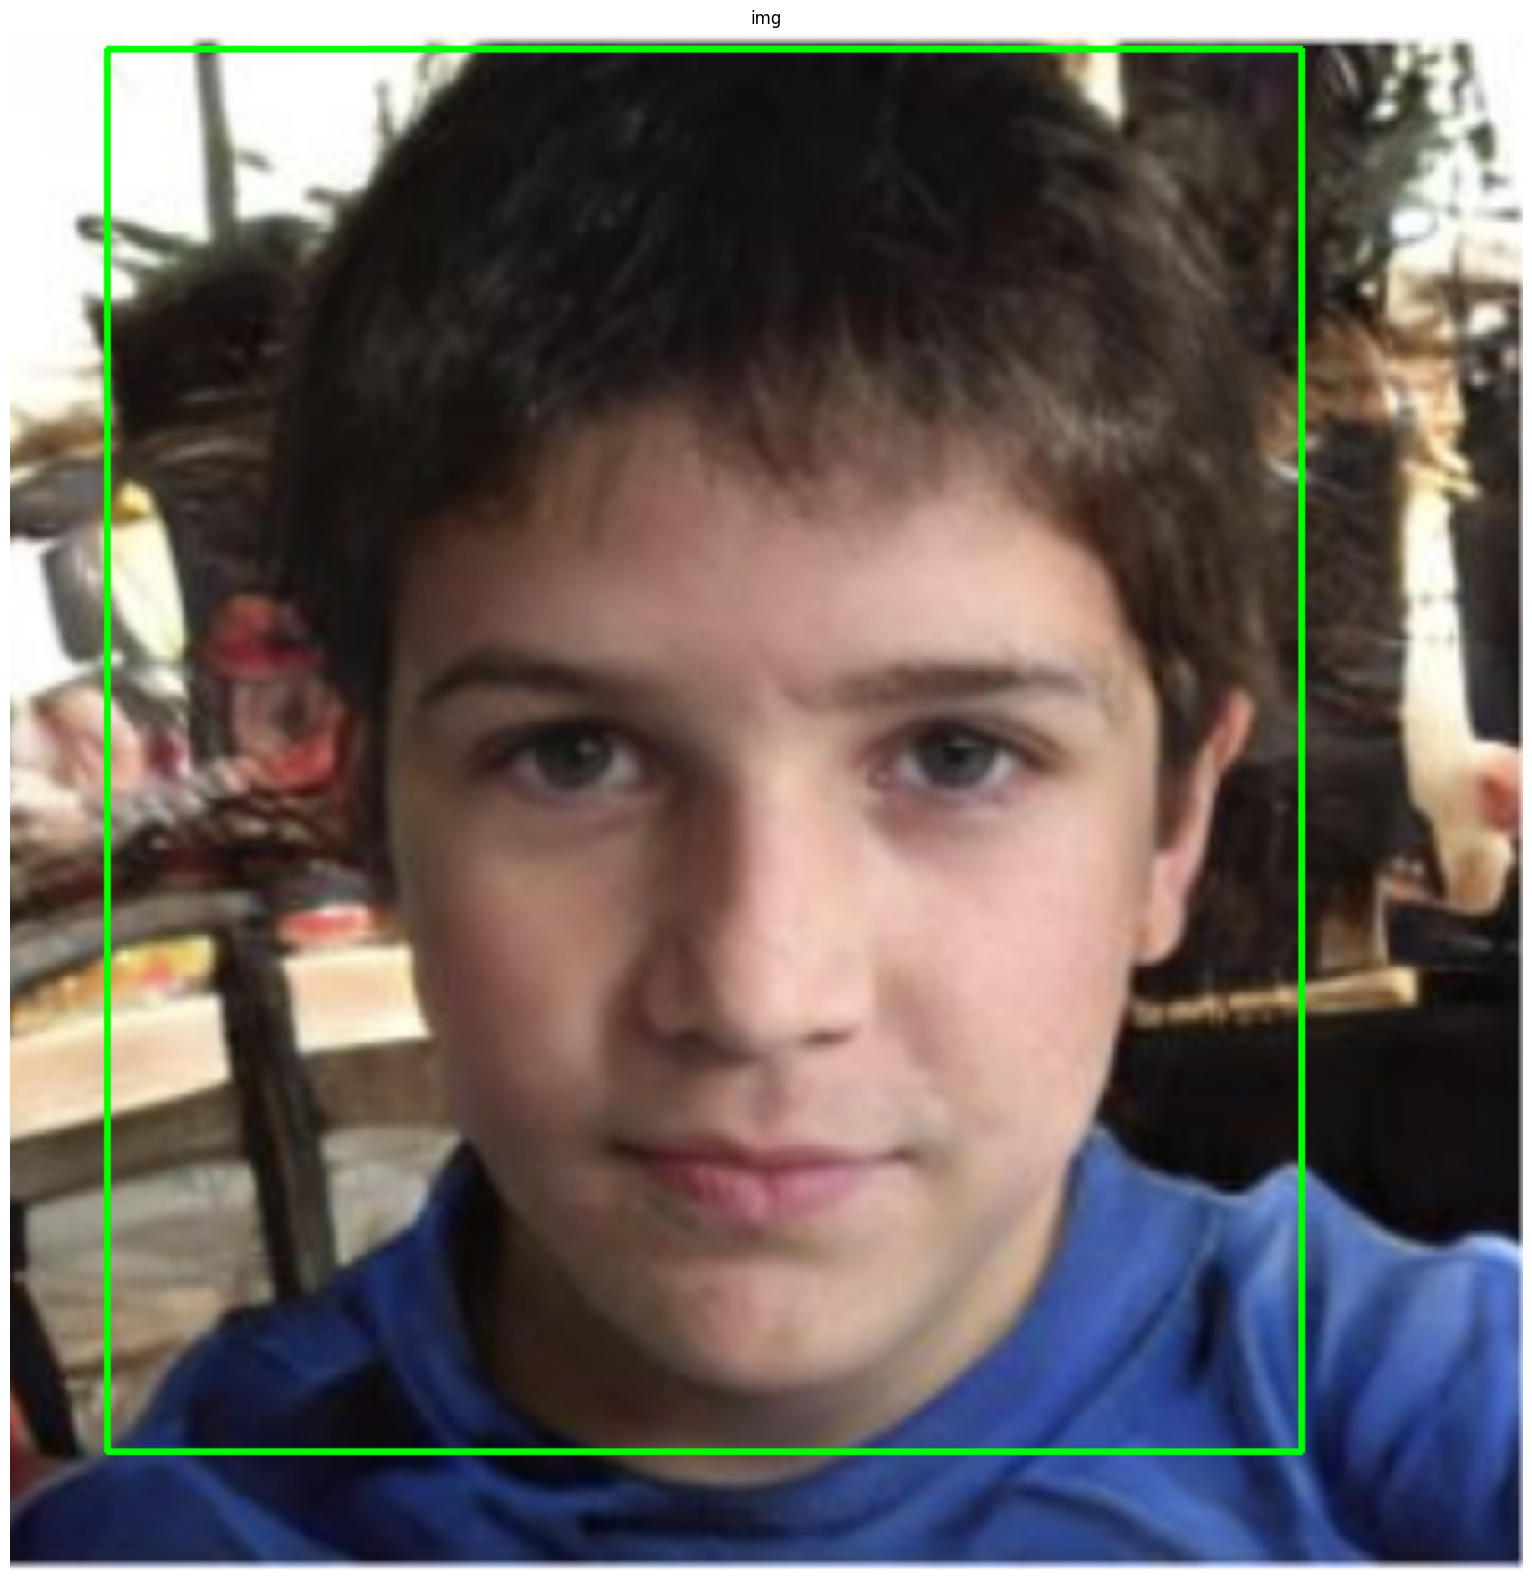

In [14]:
candidates = extract_candidates(img)
print(len(candidates))
show(img, bbs = [candidates[0]]) #try other candidates

* The grids in the preceding diagram represent the candidate regions coming from the selective_search method.

# Calculating Intersection Over Union

1. Specify the get_iou function that takes boxA and boxB as inputs where boxA and boxB are two different bounding boxes (you can consider boxA as the ground truth bounding box and boxB as the region proposal).

* We define the epsilon parameter to address the rare scenario when the union between the two boxes is 0, resulting in a division by zero error. Note that in each of the bounding boxes, there will be four values corresponding to the four corners of the bounding box.

2. Calculate the coordinates of the intersection box.

* Note that x1 is storing the maximum value of the left-most x-value between the two bounding boxes. Similarly, y1 is storing the topmost y-value and x2 and y2 are storing the right-most x-value and bottom-most y-value.

3. Calculate width and height corresponding to the intersection area (overlapping region).

4. Calculate the area of overlap (area_overlap).

* Note that we specify that if the width or height corresponding to the overlapping region is less than 0, the area of intersection is 0. Otherwise, we calculate the area of overlap (intersection) similar to the way a rectangle's area is calculated – width multiplied by the height.

5. Calculate the combined area corresponding to the two bounding boxes.

* We have calculated the combined area of the two bounding boxes – area_a and area_b, and then subtract the overlapping area while calculating area_combined, as area_overlap is counted twice, once when calculating area_a and then when calculating area_b.

6. Calculate the IoU and return it.

* We calculate iou as the ratio of the area of overlap
(area_overlap) over the area of the combined region (area_combined) and
returning it.

In [15]:
# take boxA and boxB as inputs
# epsilon parameter addresses the rare scenario when the union between the two boxes is 0
def get_iou(boxA, boxB, epsilon=1e-5):
    # Calculate the coordinates of the intersection box
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])

    # Calculate width and height
    width = (x2 - x1)
    height = (y2 - y1)

    # Calculate the area of overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # Calculate the combined area corresponding to the two bounding boxes
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap

    # Calculate the IoU and return it
    iou = area_overlap / (area_combined+epsilon)
    return iou

# Training RCNN

## downloading the dataset

1. Import the relevant packages to download files that contain images and
their ground truths.


In [16]:
!pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import *
import selectivesearch
from torchvision import transforms, models, datasets
from torch_snippets.torch_loader import Report
import torch
from torch import nn, optim
from torchvision.ops import nms
import cv2
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
!pip install gdown

In [18]:
!gdown --id '1kELYskJmdfIraJX5MtFKKf6uYaQI_wkZ'

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1kELYskJmdfIraJX5MtFKKf6uYaQI_wkZ
From (redirected): https://drive.google.com/uc?id=1kELYskJmdfIraJX5MtFKKf6uYaQI_wkZ&confirm=t&uuid=4007ead1-08de-4702-8962-760160f253de
To: /content/open-images-bus-trucks.zip
100% 391M/391M [00:03<00:00, 119MB/s]


In [19]:
!unzip -qq open-images-bus-trucks.zip

### Preparing the Dataset

Basic steps:
1. Fetching each image and its corresponding class and bounding box values.
2. Fetching the region proposals within each image, their corresponding IoU,
and the delta by which the region proposal is to be corrected with respect
to the ground truth.
3. Assigning numeric labels for each class (where we have an additional
background class (besides the bus and truck classes) where IoU with the
ground truth bounding box is below a threshold).
4. Resizing each region proposal to a common size in order to pass them to a
network.

Coding steps:
1. Specify the location of images and read the ground truths present in the
CSV file that we downloaded.

In [20]:
IMAGE_ROOT = 'archive/images/images'
DF_RAW = pd.read_csv('archive/df.csv')
print(DF_RAW.head())

            ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.34

* Note that XMin, XMax, YMin, and YMax correspond to the ground truth of
the bounding box of the image.
* LabelName provides the class
of image.

2. Define a class that returns the image and its corresponding class and
ground truth along with the file path of the image.
* Pass the data frame and the path to the folder containing
images as input to the `__init__` method and fetch
the unique ImageID values present in the data frame. We do so, as an image can contain a multiple
number of objects and so multiple rows can correspond to the same
ImageID value.
* Define the `__getitem__` method, where we fetch the image corresponding to an index, fetch its bounding box coordinates, classes, and return the image, bounding box,
class, and image path.
3. Inspect a sample image and its corresponding class and bounding box
ground truth.

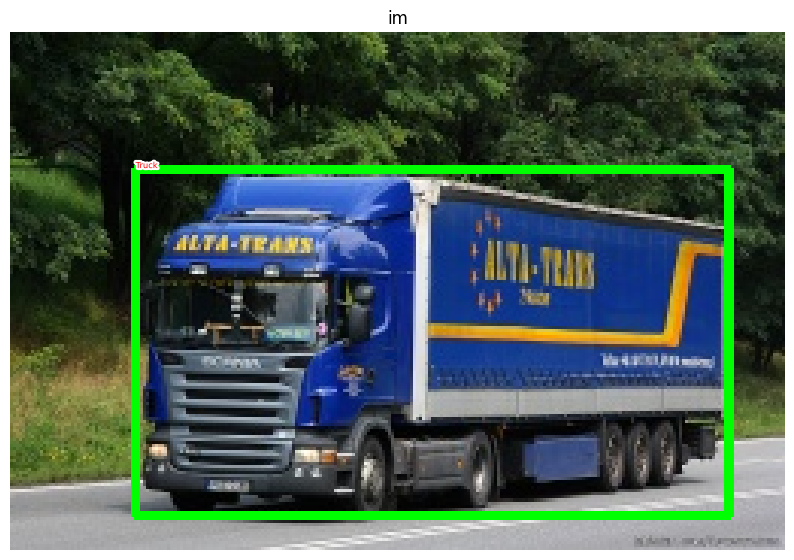

In [22]:
class OpenImages(Dataset):
    # pass dataframe and image folder as input
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder #path to root folder
        self.df = df #dataframe with labels

        # fetch unique imageID values
        self.unique_images = df['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix] #get image id
        image_path = f'{self.root}/{image_id}.jpg' #get path
        image = cv2.imread(image_path, 1)[...,::-1] # open image and convert BGR to RGB
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id] #get labels from df for image_id
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist() #multiply by width and height to denormalize
        classes = df['LabelName'].values.tolist() #classes for boxes

        # fetch the image corresponding to an index,
        # its bounding box, class, and image path
        return image, boxes, classes, image_path

# inspect a sample image and its corresponding class and bounding box
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[9]
show(im, bbs=bbs, texts=clss, sz=10)

4. Define the extract_iou and extract_candidates functions.

In [24]:
# extract candidates
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

# extract iou
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

### Fetching region proposals and the ground truth of offset

1. Initialize empty lists to store file paths, ground truth bounding
boxes, classes of objects, the delta offset of a bounding box
with region proposals, region proposal locations (region of interest), and the
IoU of region proposals with ground truths.

In [25]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []

2. Loop through the dataset and populate the lists initialized above.
* We can use all the data points for training or illustrate with just the first 500 data points. You can choose between either of the two, which dictates the training time and training accuracy (the greater the data points, the greater the training time and accuracy).
* Extract candidates from each image in absolute pixel values (note
that XMin, Xmax, YMin, and YMax are available as a proportion of the
shape of images in the downloaded data frame) using the
extract_candidates function and convert the extracted regions
coordinates from an (x,y,w,h) system to an (x,y,x+w,y+h) system.
* Initialize ious, rois, deltas, and clss as lists that store iou for each
candidate, region proposal location, bounding box offset, and class
corresponding to every candidate for each image. We will go through
all the proposals from SelectiveSearch and store those with a high IOU
as bus/truck proposals (whichever is the class in labels) and the rest as
background proposals.
* Store the IoU of all candidates with respect to all ground truths for an
image where bbs is the ground truth bounding box of different objects
present in the image and candidates are the region proposal
candidates obtained in the previous step.
* Loop through each candidate and store the XMin (cx), YMin (cy),
XMax (cX), and YMax (cY) values of a candidate.
* Extract the IoU corresponding to the candidate with respect to all the
ground truth bounding boxes that were already calculated when
fetching the list of lists of ious.
* Find the index of a candidate that has the highest IoU
and the corresponding ground truth.
* If IoU is greater than a threshold, we assign the label
of class corresponding to the candidate, and the background
otherwise.
* Fetch the offsets needed (delta) to transform the current proposal
into the candidate that is the best region proposal (which is the ground
truth bounding box) – best_bb, in other words, how much should the
left, right, top, and bottom margins of the current proposal be adjusted
so that it aligns exactly with best_bb from the ground truth.
* Append the file paths, IoU, roi, class delta, and ground truth bounding
boxes.
* Fetch the image path names and store all the information
obtained, FPATHS, IOUS, ROIS, CLSS, DELTAS, and GTBBS, in a list of
lists.

In [26]:
# using only 500 data points
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds): #iterate through dataset
    if(ix==N): #break at 500
        break

    # extract candidates from each image
    H, W, _ = im.shape
    candidates = extract_candidates(im) #generate region proposals for image
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates]) #converts candidate BBOX to standard format

    # initialize ious, rois, deltas, and clss
    ious, rois, clss, deltas = [], [], [], []

    # store the IOU of all candidates with respect to all ground truth bounding boxes for an image
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T

    # Loop through each candidate and store the x and y values of a candidate
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate

        # Extract the IoU corresponding to the candidate
        candidate_ious = ious[jx]

        # Find the index of a candidate that has the highest IoU
        # and the corresponding ground truth
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]

        # if IoU is greater than a threshold, we assign the label
        # if threshold not reached, assign as background
        if best_iou > 0.3:
            clss.append(labels[best_iou_at])
        else : clss.append('background')

        # fetch the offsets needed to transform the current proposal
        # into the candidate that is the best region proposal
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))

    # Append the file paths, IoU, roi, class delta, and ground truth bounding boxes for image
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)

# Fetch the image path names and store all the information obtained
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3

3. Assign indices to each class.

In [27]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
print(targets)

label2target = {l:t for t,l in enumerate(targets['label'].unique())}
print(label2target)

# convert class index to numeric
target2label = {t:l for l,t in label2target.items()}
print(target2label)

background_class = label2target['background']

            label
0             Bus
1             Bus
2      background
3             Bus
4      background
...           ...
20158       Truck
20159       Truck
20160       Truck
20161       Truck
20162       Truck

[20163 rows x 1 columns]
{'Bus': 0, 'background': 1, 'Truck': 2}
{0: 'Bus', 1: 'background', 2: 'Truck'}


### Creating the Training Data

1. Define the function to normalize an image.

In [28]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

2. Define a function (preprocess_image) to preprocess the image (img),
where we switch channels, normalize the image, and register it with the
device.

In [29]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()

* Define the function to the class decode prediction.

In [30]:
def decode(_y):
    _, preds = _y.max(-1) #max value across last dimension (class)
    return preds

3. Define the dataset (RCNNDataset) using the preprocessed region proposals
along with the ground truths obtained before.
* Fetch the crops as per the region proposals, along with the other
ground truths related to class and the bounding box offset.
* Define collate_fn, which performs the resizing and normalizing
(preprocess_image) of an image of a crop.

In [32]:
# Define the dataset (RCNNDataset) using the preprocessed region proposals
# along with the ground truths
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)

    # Fetch the crops, ground truths related class, and the bounding box offset
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16) #scales regoing of interest to the image size (denormalize) and converts to integer
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs] #extract crop from the image based on region of interest bbox
        return image, crops, bbs, labels, deltas, gtbbs, fpath

    # performs resizing and normalizing of and image of a crop
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops] #resize each crap to standard 224x224 for model processing
            crops = [preprocess_image(crop/255.)[None] for crop in crops] #normalize to [0,1]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels]) #convert class from categorical to numerical
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device) #make crops tensor and move to gpu
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas

4. Create the training and validation datasets and data loaders.

In [33]:
n_train = 9*len(FPATHS)//10 #90% of images
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

### R-CNN Network Architecture

basic steps:
1. Define a VGG backbone.
2. Fetch the features post passing the normalized crop through a pretrained
model.
3. Attach a linear layer with sigmoid activation to the VGG backbone to
predict the class corresponding to the region proposal.
4. Attach an additional linear layer to predict the four bounding box offsets.
5. Define the loss calculations for each of the two outputs (one to predict class
and the other to predict the four bounding box offsets).
6. Train the model that predicts both the class of region proposal and the four
bounding box offsets.


coding steps:
1. Define a VGG backbone.

In [34]:
vgg_backbone = models.vgg16(pretrained=True)
#replace classifier with empty sequential layer, we will only us output features from conv layers
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False
vgg_backbone.eval().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 77.4MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

2. Define the RCNN network module.
* Define the class.
* Define the backbone and how we calculate the class
score and the bounding box offset values.
* Define the loss functions corresponding to class prediction and bounding box offset regression.
* Define the feed-forward method where we pass the image through a
VGG backbone to fetch features, which are further passed through the methods corresponding to classification and bounding box regression to fetch the probabilities across classes and the bounding box offsets.
* Define the function to calculate loss. Note that we do not
calculate regression loss corresponding to offsets if the actual class is
of the background.

In [44]:
# define the class
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088  # dimension of features extracted by VGG conv backbone, given 224x224 image

        # define the backbone for feature extraction
        self.backbone = vgg_backbone

        # calculate the class score, mapping feature dimension to 3 output neurons
        self.cls_score = nn.Linear(feature_dim, len(label2target))

        # calculate bounding box offset values (4 dimensions: x1,y1,x2,y2)
        self.bbox = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 4),
            nn.Tanh(),
        )

        # define the loss functions for class prediction
        # and bounding box regression
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()

    # Define the feed-forward method
    def forward(self, input):
        # we pass the image through a
        # VGG backbone to fetch feature

        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)

        return cls_score, bbox

    # Define the function to calculate loss.
    # we do not calculate regression loss corresponding to offsets
    # if the actual class is of the background
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels!=1)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0 #scaling factor for regression loss + detection loss
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss


3. Define the train_batch function.

In [45]:
def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input) #predicted class and delta for input crops
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas) #calculated losses
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

4. Define the validate_batch function.

In [46]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

5. Now, let's create an object of the model, fetch the loss criterion, and then
define the optimizer and the number of epochs.

In [47]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

6. We now train the model over increasing epochs.

<ipython-input-32-d5e2a5ca6d1b>:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  deltas = torch.Tensor(deltas).float().to(device)


EPOCH: 5.000  val_loss: 1.494  val_loc_loss: 0.546  val_regr_loss: 0.095  val_acc: 0.766  (708.15s - 0.00s remaining)

100%|██████████| 106/106 [00:00<00:00, 5237.51it/s]


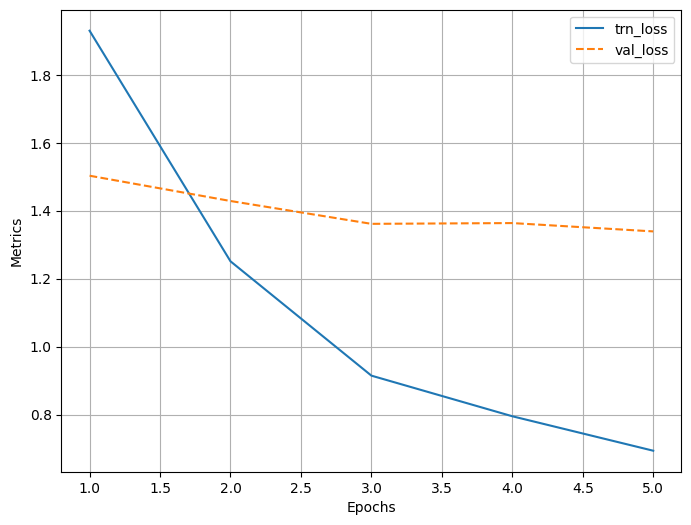

In [48]:
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn,
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss,
                   trn_regr_loss=regr_loss,
                   trn_acc=accs.mean(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs,
                                                rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss,
                val_regr_loss=regr_loss,
                val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

### Predict on a new image

basic steps:
1. Extract region proposals from the new image.
2. Resize and normalize each crop.
3. Feed-forward the processed crops to make predictions of class and the
offsets.
4. Perform non-max suppression to fetch only those boxes that have the
highest confidence of containing an object.

code steps:
1. Define the test_predictions function to predict on a new image.
* The function takes filename as input.
* Read the image and extract candidates.
* Loop through the candidates to resize and preprocess the image.
* Predict the class and offset.
* Extract the candidates that do not belong to the background class and
sum up the candidates with the predicted bounding box offset values.
* Use non-max suppression nms to eliminate near-duplicate bounding
boxes (pairs of boxes that have an IoU greater than 0.05 are considered
duplicates in this case). Among the duplicated boxes, we pick that box
with the highest confidence and discard the rest.
* Fetch the bounding box with the highest confidence.
* Plot the image along with the predicted bounding box.

In [51]:
# function to predict on a new image
def test_predictions(filename, show_output=True):
    # read the image and etract candidates
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]

    # loop through candidates to resize and preprocess the image
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)

    # Predict the class and offset
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.sigmoid(probs)
        confs, clss = torch.max(probs, -1)


    # remove from computation graph and moved to cpu for processing
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    # ignore any background class detections
    # Use non-max suppression to eliminate near-duplicate bounding boxes
    # we pick that box with the highest confidence and discard the rest
    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16) #predicted bounding boxes are adjusted by predicted deltas for final integer bboxes
    # boxes that overlap > threshold of .05 with a higher confidence bbox are suppressed
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    # filter predictions based on indices returned by non max suppression
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]

    # Fetch the bounding box with the highest confidence
    if len(ixs) == 1: # add None dimension to keep detection size of 1, prevent it from becoming scalar
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs) #index of pred with highest confidence
        best_conf = np.max(confs) #highest confidence
        best_bb = bbs[best_pred] #best bounding box prediction
        x,y,X,Y = best_bb

    # Plot the image along with the predicted bounding box
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf

2. Execute the preceding function on a new image.

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


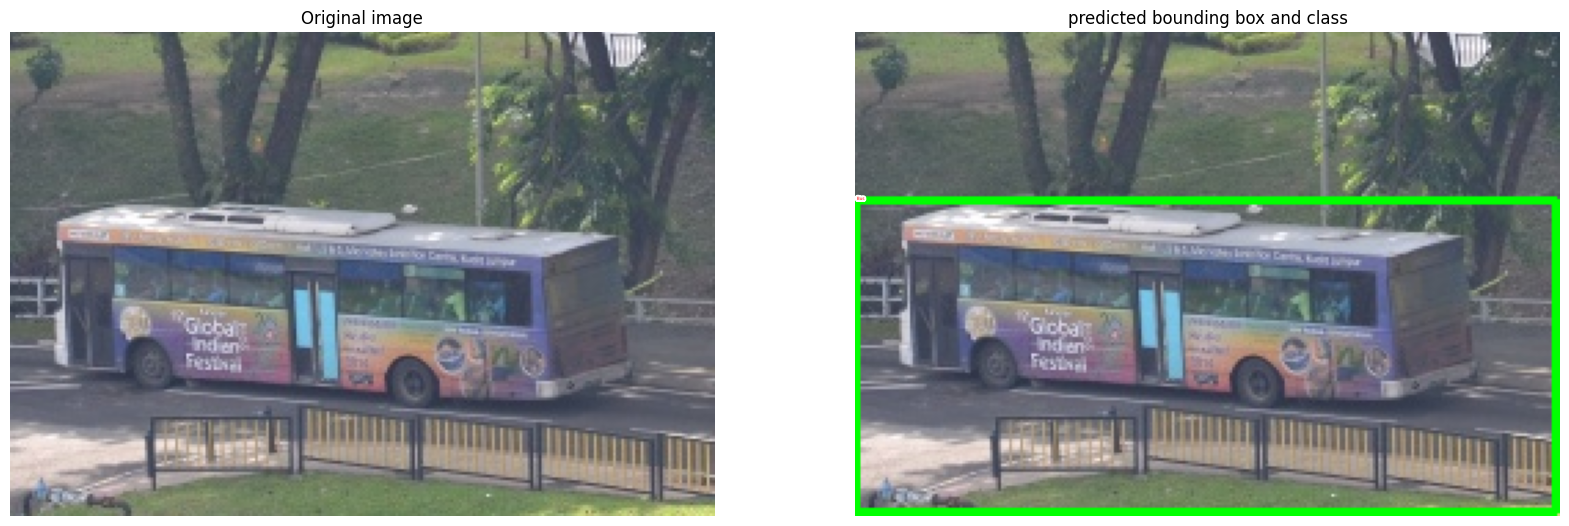

((np.uint16(0), np.uint16(61), np.uint16(254), np.uint16(174)),
 'Bus',
 np.float32(0.9366313))

In [52]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[7]
test_predictions(fpath)

# Training Fast R-CNN

basic steps:
1. Pass the image through a pretrained model to extract features prior to the
flattening layer; let's call the output as feature maps.
2. Extract region proposals corresponding to the image.
3. Extract the feature map area corresponding to the region proposals (note
that when an image is passed through a VGG16 architecture, the image is
downscaled by 32 at the output as there are 5 pooling operations
performed. Thus, if a region exists with a bounding box of (40,32,200,240)
in the original image, the feature map corresponding to the bounding box
of (5,4,25,30) would correspond to the exact same region).
4. Pass the feature maps corresponding to region proposals through the RoI
(Region of Interest) pooling layer one at a time so that all feature maps of
region proposals have a similar shape. This is a replacement for the
warping that was executed in the R-CNN technique.
5. Pass the RoI pooling layer output value through a fully connected layer.
6. Train the model to predict the class and offsets corresponding to each
region proposal.

coding steps:
* The beginning is from the above section.

In [53]:
!pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import *
import selectivesearch
from torchvision import transforms, models, datasets
from torch_snippets.torch_loader import Report
import torch
from torch import nn, optim
from torchvision.ops import nms
import cv2
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [54]:
# you can skip if file already unzipped
!unzip -qq open-images-bus-trucks.zip

replace __MACOSX/._archive? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [55]:
IMAGE_ROOT = 'archive/images/images'
DF_RAW = pd.read_csv('archive/df.csv')
print(DF_RAW.head())

            ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.34

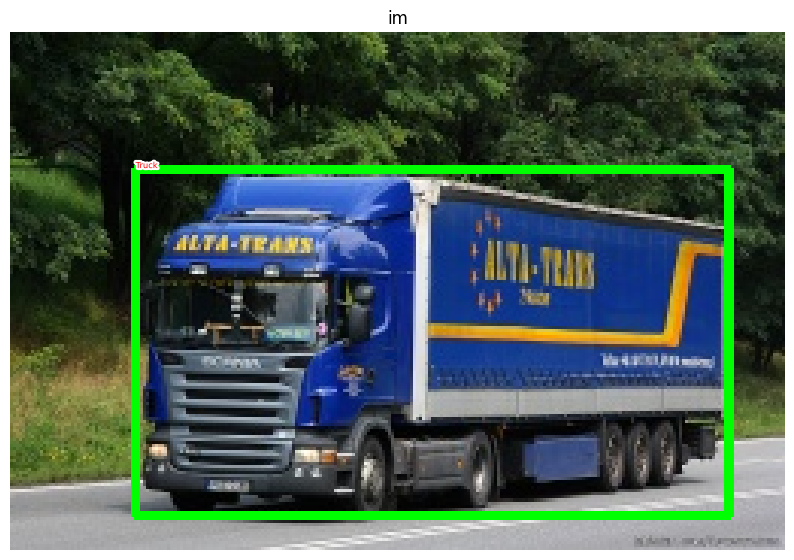

In [56]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[9]
show(im, bbs=bbs, texts=clss, sz=10)

In [57]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [58]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break
    H, W, _ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3

In [60]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

In [61]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
def decode(_y):
    _, preds = _y.max(-1)
    return preds

1. Create an FRCNNDataset class that returns images, labels, ground truths,
region proposals, and the delta corresponding to each region proposal.
* code is very similar to what we have learned in the
R-CNN section, with the only change being that we are returning more
information (rois and rixs).
* The rois matrix holds information regarding which RoI belongs to which
image in the batch. Note that input contains multiple images,
whereas rois is a single list of boxes. We wouldn't know how many rois
belong to the first image and how many belong to the second image, and so
on.
* This is where ridx comes into the picture. It is a list of indexes. Each
integer in the list associates the corresponding bounding box with the
appropriate image; for example, if ridx is [0,0,0,1,1,2,3,3,3], then we
know the first three bounding boxes belong to the first image in the batch,
and the next two belong to the second image in the batch.

In [59]:
class FRCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        assert len(rois) == len(labels) == len(deltas), f'{len(rois)}, {len(labels)}, {len(deltas)}'
        # returns images, labels, ground truths, region proposals,
        # and the delta corresponding to each region proposal
        return image, rois, labels, deltas, gtbbs, fpath

    # same as before
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, image_rois, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            image = cv2.resize(image, (224,224))
            input.append(preprocess_image(image/255.)[None])
            rois.extend(image_rois)
            rixs.extend([ix]*len(image_rois))
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        rois = torch.Tensor(rois).float().to(device)
        rixs = torch.Tensor(rixs).float().to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, rois, rixs, labels, deltas

2. Create training and test datasets.

In [62]:
n_train = 9*len(FPATHS)//10
train_ds = FRCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = FRCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

3. Define a model to train on the dataset.
* First, import the RoIPool method present in the torchvision.ops
class.
* Define the FRCNN network module.
* Load the pretrained model and freeze the parameters.
* Extract features until the last layer.
* Specify that RoIPool is to extract a 7 x 7 output.
Here, spatial_scale is the factor by which proposals (which come
from the original image) need to be shrunk so that every output has
the same shape prior to passing through the flatten layer. Images are
224 x 224 in size, while the feature map is 14 x 14 in size.
* Define the output heads – cls_score and bbox.
* Define the loss functions.
* Define the forward method, which takes the image, region proposals,
and the index of region proposals as input for the network defined
earlier.
* Pass the input image through the pretrained model.
* Create a matrix of rois as input for self.roipool, first by
concatenating ridx as the first column and the next four columns
being the absolute values of the region proposal bounding boxes.
* Define the loss value calculation, just like we did in the
R-CNN section.

In [63]:
# import the RoIPool method present in the torchvision.ops class
from torchvision.ops import RoIPool
import torchvision
# Define the FRCNN network module
class FRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Load the pretrained model and freeze the parameters
        rawnet = torchvision.models.vgg16_bn(pretrained=True)
        for param in rawnet.features.parameters():
            param.requires_grad = True

        # Extract features until the last layer
        self.seq = nn.Sequential(*list(rawnet.features.children())[:-1])

        # Specify that RoIPool is to extract a 7 x 7 output
        self.roipool = RoIPool((7,7), spatial_scale=1/16)

        # Define the output heads – cls_score and bbox
        feature_dim =
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tahn(),
            )

        # Define the loss functions
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()

    # Define the forward method, which takes the image, region proposals,
    # and the index of region proposals as input for the network
    def forward(self, input, rois, ridx):
        # Pass the input image through the pretrained model
        res = input
        res = self.seq(res)

        # Create a matrix of rois as input for self.roipool
        rois = torch.cat([ridx.unsqueeze(-1), rois*224], dim=-1)
        res = self.roipool(res, rois)
        feat = res.view(len(res), -1)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat) # .view(-1, len(label2target), 4)
        return cls_score, bbox

    # Define the loss value calculation
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != background_class)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

SyntaxError: invalid syntax (<ipython-input-63-d1c53de14206>, line 20)

4. Define the functions to train and validate on a batch just like we did in the
R-CNN section.

In [ ]:
def train_batch(inputs, model, optimizer, criterion):
    input, rois, rixs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input, rois, rixs)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()
def validate_batch(inputs, model, criterion):
    input, rois, rixs, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input, rois, rixs)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _clss = decode(_clss)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

5. Define and train the model over increasing epochs.

In [ ]:
frcnn = FRCNN().to(device)
criterion = frcnn.calc_loss
optimizer = optim.SGD(frcnn.parameters(), lr=1e-3)

n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, frcnn,
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss,
                   trn_regr_loss=regr_loss,
                   trn_acc=accs.mean(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs,
                                                frcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss,
                val_regr_loss=regr_loss,
                val_acc=accs.mean(), end='\r')

    log.report_avgs(epoch+1)

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.004  trn_loss: 2.619  trn_loc_loss: 1.186  trn_regr_loss: 0.143  trn_acc: 0.222  (0.09s - 100.97s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.009  trn_loss: 3.171  trn_loc_loss: 0.897  trn_regr_loss: 0.227  trn_acc: 0.723  (0.18s - 100.55s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.013  trn_loss: 2.881  trn_loc_loss: 1.351  trn_regr_loss: 0.153  trn_acc: 0.400  (0.26s - 96.10s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.], device='cuda:0')

EPOCH: 0.018  trn_loss: 2.590  trn_loc_loss: 0.954  trn_regr_loss: 0.164  trn_acc: 0.516  (0.32s - 89.58s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.022  trn_loss: 2.608  trn_loc_loss: 0.987  trn_regr_loss: 0.162  trn_acc: 0.446  (0.38s - 85.56s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.027  trn_loss: 3.673  trn_loc_loss: 1.600  trn_regr_loss: 0.207  trn_acc: 0.148  (0.45s - 83.03s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

EPOCH: 0.031  trn_loss: 3.468  trn_loc_loss: 1.016  trn_regr_loss: 0.245  trn_acc: 0.557  (0.51s - 81.15s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

EPOCH: 0.036  trn_loss: 2.348  trn_loc_loss: 0.964  trn_regr_loss: 0.138  trn_acc: 0.643  (0.57s - 79.82s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.], device='cuda:0')

EPOCH: 0.040  trn_loss: 2.497  trn_loc_loss: 1.050  trn_regr_loss: 0.145  trn_acc: 0.653  (0.63s - 78.28s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

EPOCH: 0.044  trn_loss: 3.096  trn_loc_loss: 1.047  trn_regr_loss: 0.205  trn_acc: 0.618  (0.69s - 77.02s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.049  trn_loss: 1.940  trn_loc_loss: 0.762  trn_regr_loss: 0.118  trn_acc: 0.914  (0.75s - 76.00s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.053  trn_loss: 2.746  trn_loc_loss: 1.169  trn_regr_loss: 0.158  trn_acc: 0.494  (0.81s - 75.18s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.058  trn_loss: 2.178  trn_loc_loss: 0.885  trn_regr_loss: 0.129  trn_acc: 0.726  (0.87s - 74.73s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

EPOCH: 0.062  trn_loss: 2.392  trn_loc_loss: 1.028  trn_regr_loss: 0.136  trn_acc: 0.443  (0.94s - 74.27s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.067  trn_loss: 2.040  trn_loc_loss: 0.953  trn_regr_loss: 0.109  trn_acc: 0.579  (0.99s - 73.62s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

EPOCH: 0.071  trn_loss: 2.507  trn_loc_loss: 1.093  trn_regr_loss: 0.141  trn_acc: 0.455  (1.06s - 73.26s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.], device='cuda:0')

EPOCH: 0.076  trn_loss: 2.407  trn_loc_loss: 0.712  trn_regr_loss: 0.169  trn_acc: 0.780  (1.12s - 72.99s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.], device='cuda:0')

EPOCH: 0.080  trn_loss: 2.888  trn_loc_loss: 1.065  trn_regr_loss: 0.182  trn_acc: 0.626  (1.18s - 72.77s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.], device='cuda:0')

EPOCH: 0.084  trn_loss: 2.527  trn_loc_loss: 1.022  trn_regr_loss: 0.150  trn_acc: 0.589  (1.24s - 72.38s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.], device='cuda:0')

EPOCH: 0.089  trn_loss: 2.350  trn_loc_loss: 1.029  trn_regr_loss: 0.132  trn_acc: 0.533  (1.31s - 72.12s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:0')

EPOCH: 0.093  trn_loss: 2.091  trn_loc_loss: 0.875  trn_regr_loss: 0.122  trn_acc: 0.826  (1.37s - 71.98s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

EPOCH: 0.098  trn_loss: 2.275  trn_loc_loss: 1.019  trn_regr_loss: 0.126  trn_acc: 0.598  (1.43s - 71.73s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:0')

EPOCH: 0.102  trn_loss: 2.316  trn_loc_loss: 1.004  trn_regr_loss: 0.131  trn_acc: 0.522  (1.49s - 71.52s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

EPOCH: 0.107  trn_loss: 2.122  trn_loc_loss: 0.950  trn_regr_loss: 0.117  trn_acc: 0.603  (1.55s - 71.24s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

EPOCH: 0.111  trn_loss: 2.177  trn_loc_loss: 1.111  trn_regr_loss: 0.107  trn_acc: 0.586  (1.61s - 70.94s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.116  trn_loss: 1.987  trn_loc_loss: 0.761  trn_regr_loss: 0.123  trn_acc: 0.790  (1.67s - 70.74s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.], device='cuda:0')

EPOCH: 0.120  trn_loss: 2.303  trn_loc_loss: 0.767  trn_regr_loss: 0.154  trn_acc: 0.740  (1.73s - 70.53s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.124  trn_loss: 2.512  trn_loc_loss: 0.812  trn_regr_loss: 0.170  trn_acc: 0.667  (1.80s - 70.39s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.129  trn_loss: 2.063  trn_loc_loss: 0.878  trn_regr_loss: 0.118  trn_acc: 0.574  (1.85s - 70.11s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

EPOCH: 0.133  trn_loss: 2.039  trn_loc_loss: 0.800  trn_regr_loss: 0.124  trn_acc: 0.792  (1.92s - 69.92s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.], device='cuda:0')

EPOCH: 0.138  trn_loss: 2.116  trn_loc_loss: 1.019  trn_regr_loss: 0.110  trn_acc: 0.684  (1.98s - 69.86s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

EPOCH: 0.142  trn_loss: 2.966  trn_loc_loss: 0.936  trn_regr_loss: 0.203  trn_acc: 0.425  (2.04s - 69.67s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:0')

EPOCH: 0.147  trn_loss: 2.966  trn_loc_loss: 1.629  trn_regr_loss: 0.134  trn_acc: 0.311  (2.10s - 69.53s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.151  trn_loss: 2.125  trn_loc_loss: 0.963  trn_regr_loss: 0.116  trn_acc: 0.500  (2.16s - 69.44s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.156  trn_loss: 2.655  trn_loc_loss: 1.039  trn_regr_loss: 0.162  trn_acc: 0.516  (2.22s - 69.26s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.160  trn_loss: 1.867  trn_loc_loss: 0.748  trn_regr_loss: 0.112  trn_acc: 0.915  (2.29s - 69.13s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.164  trn_loss: 1.748  trn_loc_loss: 0.773  trn_regr_loss: 0.098  trn_acc: 0.759  (2.35s - 68.98s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.169  trn_loss: 2.426  trn_loc_loss: 0.985  trn_regr_loss: 0.144  trn_acc: 0.521  (2.41s - 68.97s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

EPOCH: 0.173  trn_loss: 1.799  trn_loc_loss: 0.844  trn_regr_loss: 0.096  trn_acc: 0.736  (2.47s - 68.84s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.178  trn_loss: 2.149  trn_loc_loss: 0.976  trn_regr_loss: 0.117  trn_acc: 0.506  (2.53s - 68.67s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

EPOCH: 0.182  trn_loss: 2.501  trn_loc_loss: 1.000  trn_regr_loss: 0.150  trn_acc: 0.657  (2.60s - 68.66s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.187  trn_loss: 2.065  trn_loc_loss: 1.009  trn_regr_loss: 0.106  trn_acc: 0.455  (2.66s - 68.55s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

EPOCH: 0.191  trn_loss: 2.064  trn_loc_loss: 1.093  trn_regr_loss: 0.097  trn_acc: 0.556  (2.72s - 68.42s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.196  trn_loss: 2.374  trn_loc_loss: 0.996  trn_regr_loss: 0.138  trn_acc: 0.429  (2.78s - 68.27s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.], device='cuda:0')

EPOCH: 0.200  trn_loss: 2.104  trn_loc_loss: 1.019  trn_regr_loss: 0.109  trn_acc: 0.456  (2.84s - 68.18s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

EPOCH: 0.204  trn_loss: 1.982  trn_loc_loss: 0.943  trn_regr_loss: 0.104  trn_acc: 0.567  (2.90s - 68.13s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

EPOCH: 0.209  trn_loss: 2.072  trn_loc_loss: 0.997  trn_regr_loss: 0.107  trn_acc: 0.500  (2.97s - 68.07s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

EPOCH: 0.213  trn_loss: 1.591  trn_loc_loss: 0.750  trn_regr_loss: 0.084  trn_acc: 0.926  (3.03s - 68.03s remaining)

1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:0')

KeyboardInterrupt: 

6. Define a function to predict on test images.
* Define the function that takes a filename as input and then reads
the file and resizes it to 224 x 224.
* Obtain region proposals and convert them to (x1,y1,x2,y2) format (topleft
pixel and bottom-right pixel coordinates), and then convert these
values to the ratio of width and height they are present in, in
proportion to the image.
* Preprocess the image and scale the region of interests.
* As all proposals belong to the same image, rixs will be a list of zeros
(as many as the number of proposals).
* Forward propagate the input and rois through the trained model and
get confidences and class scores for each proposal.
* Filter out the background class.
* Remove near-duplicate bounding boxes with nms and get indices of
those proposals in which the models that are highly confident are
objects.
* Plot the bounding boxes obtained.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image

# Define the function that takes a filename as input and then reads
# the file and resizes it to 224 x 224
def test_predictions(filename):
    img = cv2.resize(np.array(Image.open(filename)), (224,224))

    # Obtain region proposals and convert them to (x1,y1,x2,y2) format
    # convert these values to the ratio of width and height they are present in, in
    # proportion to the image
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]

    # Preprocess the image and scale the region of interests
    input = preprocess_image(img/255.)[None]
    rois = [[x/224,y/224,X/224,Y/224] for x,y,X,Y in candidates]

    # As all proposals belong to the same image, rixs will be a list of zeros
    rixs = np.array([0]*len(rois))

    # Forward propagate the input and rois through the trained model and
    # get confidences and class scores for each proposal
    rois, rixs = [torch.Tensor(item).to(device) for item in [rois, rixs]]
    with torch.no_grad():
        frcnn.eval()
        probs, deltas = frcnn(input, rois, rixs)
        confs, clss = torch.max(probs, -1)

    # Filter out the background class
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = candidates + deltas

    # Remove near-duplicate bounding boxes with nms and get indices of
    # those proposals in which the models that are highly confident are objects
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]

    bbs = bbs.astype(np.uint16)

    # Plot the bounding boxes obtained
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title(filename.split('/')[-1])
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    else:
        show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
        plt.show()

7. Predict on a test image.

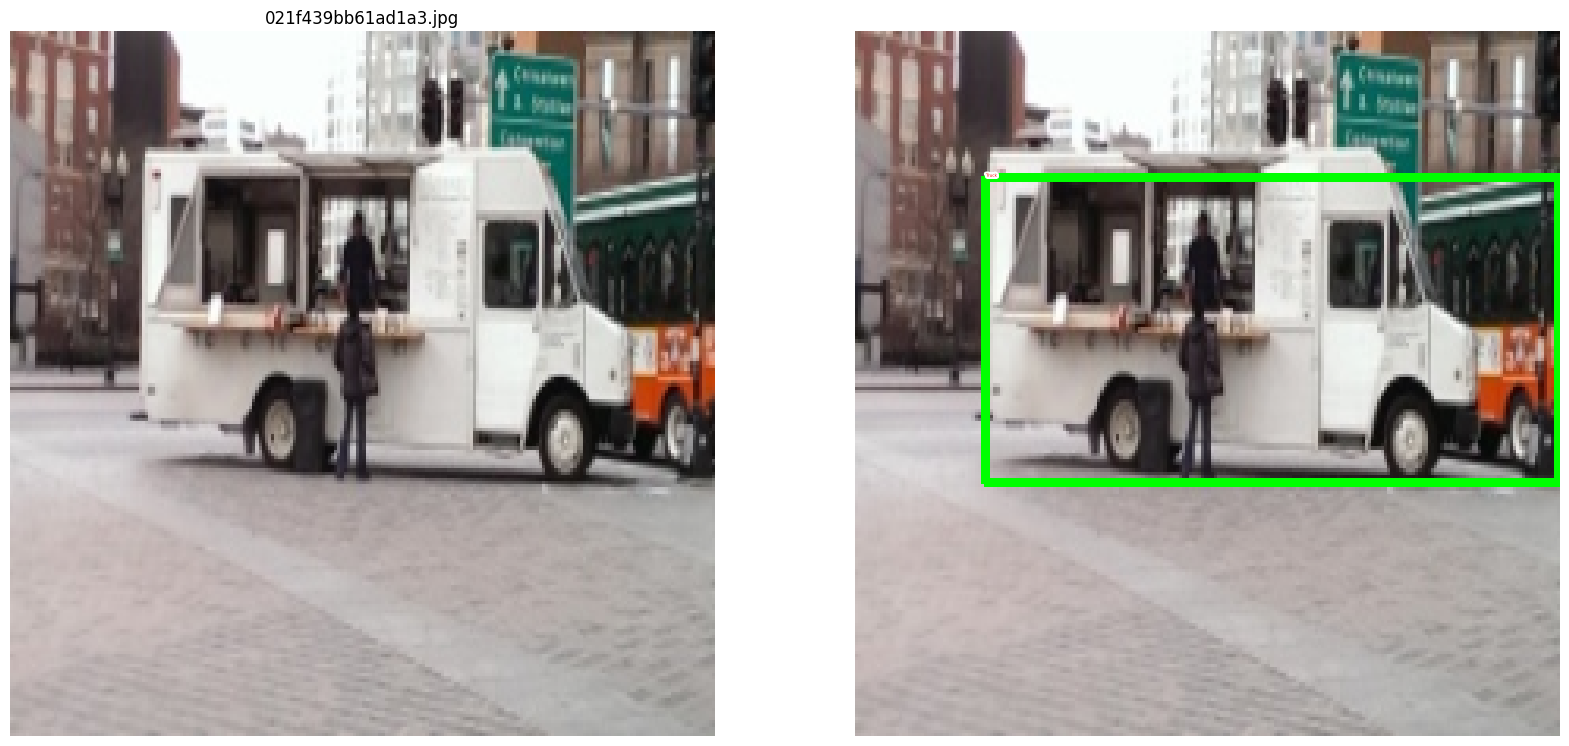

In [ ]:
test_predictions(test_ds[29][-1])